RESULT NODE 1
Best lambda: 0.08961546728890907
Indices of the non-zero regression coefficients: [  8  23  49  74 110 135 156 160 169 184 195 213 222 237 238 263 267 284
 290 294 305 348 357 360 365 366 377 395 416 417 446 473 490 505 514 516
 523 546 556 565 568 570 577 592 600]
Test loss of the final model selected: 1.017313
RESULT NODE 2
Best lambda: 0.06992677831800188
Indices of the non-zero regression coefficients: [  1   2  19  20  21  31  43  87  94 111 135 141 143 152 154 162 165 170
 171 172 191 194 196 202 219 228 229 232 247 261 263 276 315 316 354 357
 374 404 405 416 420 435 437 457 473 477 481 493 494 500 501 519 529 535
 539 553 582 598 600]
Test loss of the final model selected: 0.956203
RESULT NODE 3
Best lambda: 0.05742837645867778
Indices of the non-zero regression coefficients: [  1  12  13  17  24  41  46  80 100 105 124 137 140 166 204 205 215 229
 235 245 252 258 288 294 303 310 331 334 378 395 400 411 417 426 457 463
 465 478 479 511 514 517 525 526 534 539 574 

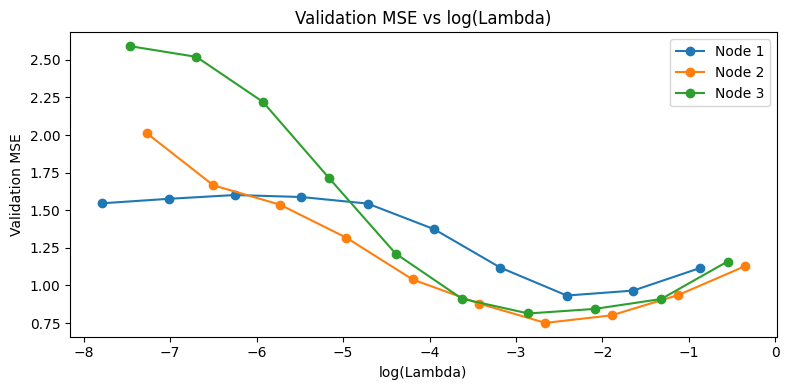

Indices of the regression coefficients that are non-zero across all three models:
600


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Soft-thresholding function

def soft_threshold(z, lambda_val):
    return np.sign(z) * np.maximum(np.abs(z) - lambda_val, 0)


# Coordinate Descent for Lasso Regression

def cd_lasso(X, y, lambda_val, tol=1e-4, max_iter=200):
    n_obs, n_feat = X.shape
    beta_vec = np.zeros(n_feat)
    for _ in range(max_iter):
        beta_prev = beta_vec.copy()
        for j in range(n_feat):
            r_j = y - X @ beta_vec + X[:, j] * beta_vec[j]
            rho_j = np.sum(X[:, j] * r_j) / n_obs
            denom_j = np.sum(X[:, j] ** 2) / n_obs
            beta_vec[j] = soft_threshold(rho_j, lambda_val) / denom_j
        diff_norm = np.sqrt(np.sum((beta_vec - beta_prev) ** 2))
        if diff_norm < tol:
            break
    return beta_vec


# Lambda grid generation

def make_lambda_grid(X, y, grid_size=10):
    X_centered = X - X.mean(axis=0, keepdims=True)
    y_centered = y - y.mean()
    n = X.shape[0]
    lambda_max = np.max(np.abs(X_centered.T @ y_centered)) / n
    lambda_seq = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_max * 1e-3), grid_size))
    return lambda_seq


# Main model training and evaluation function

def fit_and_eval(file_train, file_test, grid_size=10):
    df = pd.read_csv(file_train)
    X_all = df.iloc[:, :600].to_numpy()
    y_all = df.iloc[:, 600].to_numpy(dtype=float)

    n_total = X_all.shape[0]
    split_index = int(np.floor(0.8 * n_total))
    X_train = X_all[:split_index]
    y_train = y_all[:split_index]
    X_vali = X_all[split_index:]
    y_vali = y_all[split_index:]

    X_mean = X_train.mean(axis=0)
    y_mean = y_train.mean()
    X_train_c = X_train - X_mean
    y_train_c = y_train - y_mean
    X_vali_c = X_vali - X_mean

    lambda_values = make_lambda_grid(X_train, y_train, grid_size)
    val_errors = np.zeros(len(lambda_values))

    for i, lam in enumerate(lambda_values):
        beta_hat = cd_lasso(X_train_c, y_train_c, lam)
        intercept = y_mean - np.sum(beta_hat * X_mean)
        y_pred = X_vali @ beta_hat + intercept
        val_errors[i] = np.mean((y_vali - y_pred) ** 2)

    best_idx = int(np.argmin(val_errors))
    best_lambda = lambda_values[best_idx]

    X_combined = np.vstack([X_train, X_vali])
    y_combined = np.concatenate([y_train, y_vali])
    X_comb_mean = X_combined.mean(axis=0)
    y_comb_mean = y_combined.mean()
    X_comb_c = X_combined - X_comb_mean
    y_comb_c = y_combined - y_comb_mean

    final_beta = cd_lasso(X_comb_c, y_comb_c, best_lambda)
    final_intercept = y_comb_mean - np.sum(final_beta * X_comb_mean)

    df_test = pd.read_csv(file_test)
    X_test = df_test.iloc[:, :600].to_numpy()
    y_test = df_test.iloc[:, 600].to_numpy(dtype=float)
    y_test_pred = X_test @ final_beta + final_intercept
    test_mse = np.mean((y_test - y_test_pred) ** 2)

    return {
        "lambda": best_lambda,
        "nonzero": np.where(final_beta != 0)[0] + 1,
        "test_mse": test_mse,
        "val_errors": val_errors,
        "lambda_values": lambda_values,
    }


# File paths

data_dir = Path('.')
file_test = data_dir / 'test_data.csv'
nodes = [
    data_dir / 'regression_data_node1.csv',
    data_dir / 'regression_data_node2.csv',
    data_dir / 'regression_data_node3.csv',
]

results_list = []
val_plot_rows = []

for i, file_train in enumerate(nodes, start=1):
    print(f"RESULT NODE {i}")

    result = fit_and_eval(file_train, file_test, grid_size=10)

    print(f"Best lambda: {result['lambda']}")
    print("Indices of the non-zero regression coefficients:", result["nonzero"])
    print(f"Test loss of the final model selected: {result['test_mse']:.6f}")

    for lam, val_err in zip(result["lambda_values"], result["val_errors"]):
        val_plot_rows.append({
            "Node": f"Node {i}",
            "Lambda": lam,
            "Validation_MSE": val_err,
        })
    results_list.append(result)

val_plot_data = pd.DataFrame(val_plot_rows)

# Plot validation MSE vs log(lambda)
plt.figure(figsize=(8, 4))
for node, df_node in val_plot_data.groupby("Node"):
    plt.plot(np.log(df_node["Lambda"]), df_node["Validation_MSE"], marker='o', label=node)
plt.title("Validation MSE vs log(Lambda)")
plt.xlabel("log(Lambda)")
plt.ylabel("Validation MSE")
plt.legend()
plt.tight_layout()
plt.show()

common_nzc = set(results_list[0]["nonzero"]).intersection(
    results_list[1]["nonzero"], results_list[2]["nonzero"]
)
print("Indices of the regression coefficients that are non-zero across all three models:")
print(", ".join(str(idx) for idx in sorted(common_nzc)))

